라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 1
model_name = 'Test231004_tank1_gan_all'

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [6]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_training_food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_training_sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_sensor_val_tb.csv")

# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)

# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()


In [7]:
japonica_training_features_X = japonica_training_data[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]

japonica_validation_features_X = japonica_validation_data[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [8]:
japonica_training_features_X_chunks = []
japonica_training_features_y_chunks = []

for i in range(0, len(japonica_training_features_X) - 179):
    japonica_training_features_X_chunks.append(np.array(japonica_training_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_X_chunks = np.array(japonica_training_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_training_features_y) - 179):
    japonica_training_features_y_chunks.append(np.array(japonica_training_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_y_chunks = np.array(japonica_training_features_y_chunks, dtype=np.float64)

In [9]:
japonica_validation_features_X_chunks = []
japonica_validation_features_y_chunks = []


for i in range(0, len(japonica_validation_features_X) - 179):
    japonica_validation_features_X_chunks.append(np.array(japonica_validation_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_X_chunks = np.array(japonica_validation_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_validation_features_y) - 179):
    japonica_validation_features_y_chunks.append(np.array(japonica_validation_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_y_chunks = np.array(japonica_validation_features_y_chunks, dtype=np.float64)

In [10]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 187021 nVar: 9
nCar: 187021 nVar: 180
nCar: 187021 nVar: 9
nCar: 187021 nVar: 180


In [11]:
japonica_training_features_X_chunks_crop = japonica_training_features_X_chunks[:-180]
japonica_training_features_y_chunks_crop = japonica_training_features_y_chunks[180:]

japonica_validation_features_X_chunks_crop = japonica_validation_features_X_chunks[:-180]
japonica_validation_features_y_chunks_crop = japonica_validation_features_y_chunks[180:]

In [12]:
nCar = japonica_training_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 186841 nVar: 9
nCar: 186841 nVar: 180
nCar: 186841 nVar: 9
nCar: 186841 nVar: 180


GAN 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, LeakyReLU, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 데이터 생성 (임의의 시계열 데이터)
sequence_length = 180  # 시계열 길이
data_dim = 9  # 데이터 차원
data = japonica_training_features_X_chunks_crop

# 생성자 (Generator) 모델 정의
def build_generator():
    model = tf.keras.Sequential()
    model.add(Input(shape=(sequence_length, data_dim)))
    model.add(LSTM(64, return_sequences=True))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dense(data_dim, activation='tanh'))
    return model

generator = build_generator()

# 판별자 (Discriminator) 모델 정의
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(Input(shape=(sequence_length, data_dim)))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(LeakyReLU())
    model.add(Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

# GAN 모델 정의
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(sequence_length, data_dim))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return gan

gan = build_gan(generator, discriminator)

# GAN 학습
epochs = 10000
batch_size = 32

for epoch in range(epochs):
    noise = np.random.randn(batch_size, sequence_length, data_dim)
    generated_data = generator.predict(noise)
    
    real_data = data[np.random.randint(0, data.shape[0], batch_size)]
    real_label = np.ones((batch_size, 1))
    fake_label = np.zeros((batch_size, 1))
    
    d_loss_real = discriminator.train_on_batch(real_data, real_label)
    d_loss_fake = discriminator.train_on_batch(generated_data, fake_label)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    noise = np.random.randn(batch_size, sequence_length, data_dim)
    gan_label = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, gan_label)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss}, G Loss: {g_loss}")

# 3시간 후의 값을 예측
noise_input = np.random.randn(1, sequence_length, data_dim)
predicted_data = generator.predict(noise_input)
print("Predicted Data (3 Hours Later):", predicted_data[0][-1])


1/1 [==============================] - 1s 666ms/step
Epoch 0, D Loss: 0.33393365144729614, G Loss: 1.0912669897079468
1/1 [==============================] - 0s 37ms/step
Epoch 100, D Loss: 0.2688707113265991, G Loss: 0.08591680973768234
1/1 [==============================] - 0s 37ms/step
Epoch 200, D Loss: 0.3181665539741516, G Loss: 0.298789381980896
1/1 [==============================] - 0s 36ms/step
Epoch 300, D Loss: 0.011890264227986336, G Loss: 0.27549993991851807
1/1 [==============================] - 0s 48ms/step
Epoch 400, D Loss: 0.0037166939582722824, G Loss: 0.24168750643730164
1/1 [==============================] - 0s 36ms/step
Epoch 500, D Loss: 0.0005886884173609407, G Loss: 0.1134047657251358
1/1 [==============================] - 0s 38ms/step
Epoch 600, D Loss: 0.005911081563682159, G Loss: 0.22280463576316833
1/1 [==============================] - 0s 38ms/step
Epoch 700, D Loss: 0.031035052612423897, G Loss: 2.4439969062805176
1/1 [==============================] - 0s

In [14]:
generator.save(model_name+'.h5')

In [13]:
# LSTM 모델 생성
model = Sequential()
model.add(LSTM(128, input_shape=(180, 9), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(180, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(japonica_training_features_X_chunks_crop, japonica_training_features_y_chunks_crop, epochs = 200, batch_size = 32, validation_data=(japonica_validation_features_X_chunks_crop, japonica_validation_features_y_chunks_crop), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

2023-07-18 05:48:29.776358: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 05:48:30.420571: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 180, 128)          70656     
_________________________________________________________________
lstm_1 (LSTM)                (None, 180, 64)           49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 180)               5940      
Total params: 138,420
Trainable params: 138,420
Non-trainable params: 0
_________________________________________________________________


2023-07-18 05:48:32.358349: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2023-07-18 05:48:36.580367: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2023-07-18 05:48:37.482586: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2014/2014 [==============================] - 95s 45ms/step - loss: 5.0628 - mae: 1.4406 - r_squared: -2.7673 - val_loss: 1.4693 - val_mae: 0.9117 - val_r_squared: -37.3860
Epoch 2/200
2014/2014 [==============================] - 89s 44ms/step - loss: 1.4701 - mae: 0.9112 - r_squared: -0.0329 - val_loss: 1.4719 - val_mae: 0.9094 - val_r_squared: -36.7778
Epoch 3/200
2014/2014 [==============================] - 88s 43ms/step - loss: 1.4710 - mae: 0.9116 - r_squared: -0.0327 - val_loss: 1.4760 - val_mae: 0.9173 - val_r_squared: -38.1361
Epoch 4/200
2014/2014 [==============================] - 92s 46ms/step - loss: 0.4852 - mae: 0.4695 - r_squared: 0.6520 - val_loss: 0.3333 - val_mae: 0.3794 - val_r_squared: -2.8980
Epoch 5/200
2014/2014 [==============================] - 92s 46ms/step - loss: 0.3430 - mae: 0.3880 - r_squared: 0.7494 - val_loss: 0.3318 - val_mae: 0.3842 - val_r_squared: -3.0372
Epoch 6/200
2014/2014 [==============================] - 97s 48ms/step - loss: 0.3353 - mae: 0.3

2014/2014 [==============================] - 89s 44ms/step - loss: 0.1429 - mae: 0.2655 - r_squared: 0.8929 - val_loss: 0.1428 - val_mae: 0.2656 - val_r_squared: -0.8191
Epoch 89/200
2014/2014 [==============================] - 92s 46ms/step - loss: 0.1428 - mae: 0.2654 - r_squared: 0.8925 - val_loss: 0.1428 - val_mae: 0.2654 - val_r_squared: -0.8108
Epoch 90/200
2014/2014 [==============================] - 91s 45ms/step - loss: 0.1428 - mae: 0.2654 - r_squared: 0.8933 - val_loss: 0.1427 - val_mae: 0.2652 - val_r_squared: -0.8047
Epoch 91/200
2014/2014 [==============================] - 86s 43ms/step - loss: 0.1427 - mae: 0.2653 - r_squared: 0.8924 - val_loss: 0.1426 - val_mae: 0.2652 - val_r_squared: -0.8148
Epoch 92/200
2014/2014 [==============================] - 88s 44ms/step - loss: 0.1426 - mae: 0.2653 - r_squared: 0.8934 - val_loss: 0.1426 - val_mae: 0.2652 - val_r_squared: -0.8085
Epoch 93/200
2014/2014 [==============================] - 85s 42ms/step - loss: 0.1426 - mae: 0.26

모델 평가

In [15]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [16]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[ 0.01820422  0.13243428 -0.05888559 ...  0.02227727 -0.1090652
  -0.12614481]
 [-0.04419743  0.07361224  0.04552926 ... -0.06671768  0.04256251
   0.06880238]
 [ 0.14404236  0.02355419 -0.0301548  ...  0.08615782  0.12142299
   0.08234886]
 ...
 [ 0.14513205  0.13119924 -0.01841017 ...  0.04023384 -0.08061454
  -0.11025544]
 [ 0.11106195 -0.06025571 -0.09854733 ...  0.01374622  0.08559762
   0.08356787]
 [ 0.04268153  0.07774634  0.06612982 ...  0.06737303 -0.07343118
   0.14079924]]


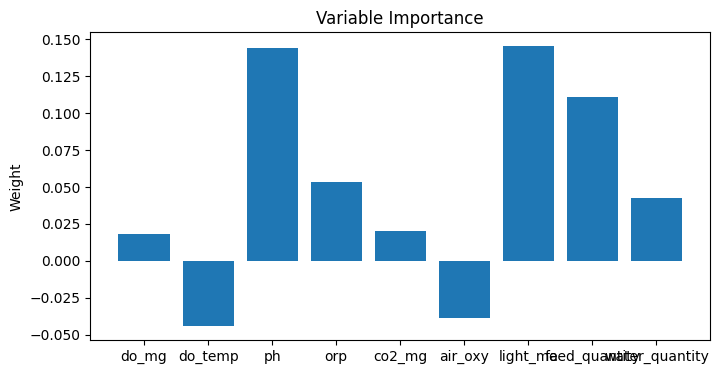

In [17]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(9), weights[:, 0])
ax.set_xticks(range(9))
ax.set_xticklabels(['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [19]:
japonica_validation_features_X

,do_mg,do_temp,ph,orp,co2_mg,air_oxy,light_ma,feed_quantity,water_quantity
mea_dt,,,,,,,,,
2021-07-21 00:00:00,7.7,30.2,5.57,195.6,13.7,0.0,3.9,0.0,0.0
2021-07-21 00:01:00,7.8,30.2,5.57,195.9,13.7,0.0,4.0,0.0,0.0
2021-07-21 00:02:00,7.8,30.2,5.57,196.1,13.7,0.0,4.0,0.0,0.0
2021-07-21 00:03:00,7.8,30.2,5.57,196.4,13.7,0.0,3.9,0.0,0.0
2021-07-21 00:04:00,7.9,30.2,5.57,196.6,13.8,0.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2021-09-08 23:55:00,8.7,29.0,5.25,149.3,22.3,0.0,3.9,0.0,0.0
2021-09-08 23:56:00,8.7,29.0,5.25,149.8,22.3,0.0,3.9,0.0,0.0
2021-09-08 23:57:00,8.7,29.0,5.25,149.9,22.3,0.0,4.0,0.0,0.0


In [18]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-09-10 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 360 nVar: 180


In [19]:
y_date = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-09-10 20:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64800 nVar: 1
nCar: 360 nVar: 180


12/12 [==============================] - 1s 70ms/step
583200


ValueError: x and y must have same first dimension, but have shapes (64800,) and (583200,)

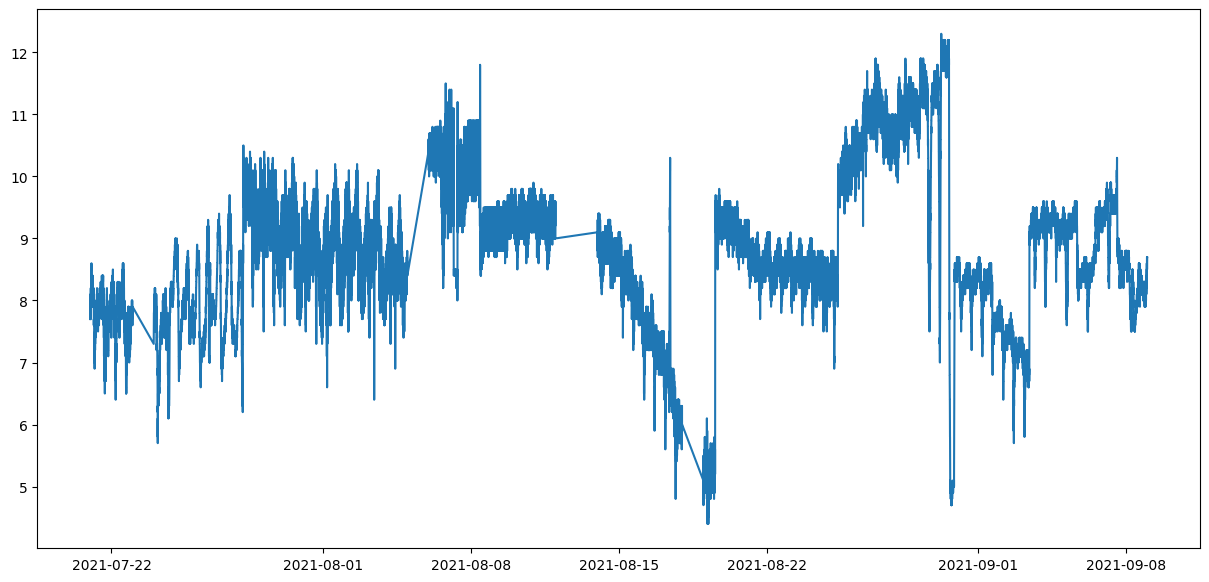

In [20]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [20]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-31 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14220 nVar: 2


In [21]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-31 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14220 nVar: 1
nCar: 14220 nVar: 1


14220


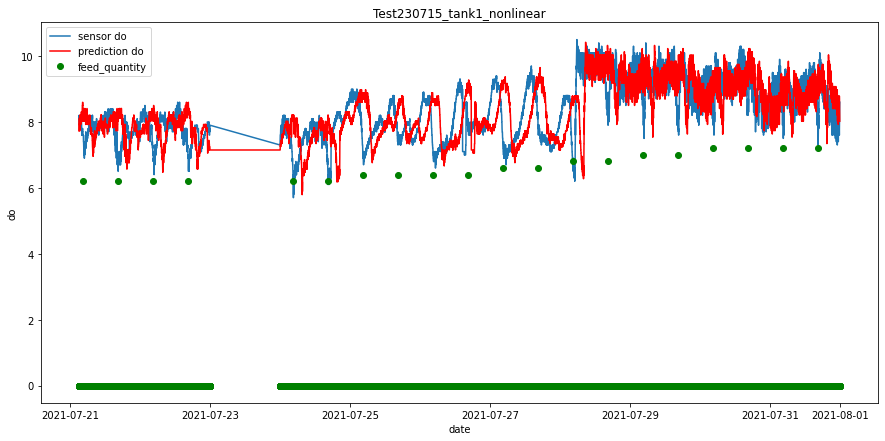

445/445 [==============================] - 2s 3ms/step - loss: 0.6651
MSE // MAE // R-squared  0.6651027202606201


In [22]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [23]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1260 nVar: 2


In [24]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-21 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1260 nVar: 1
nCar: 1260 nVar: 1


1260


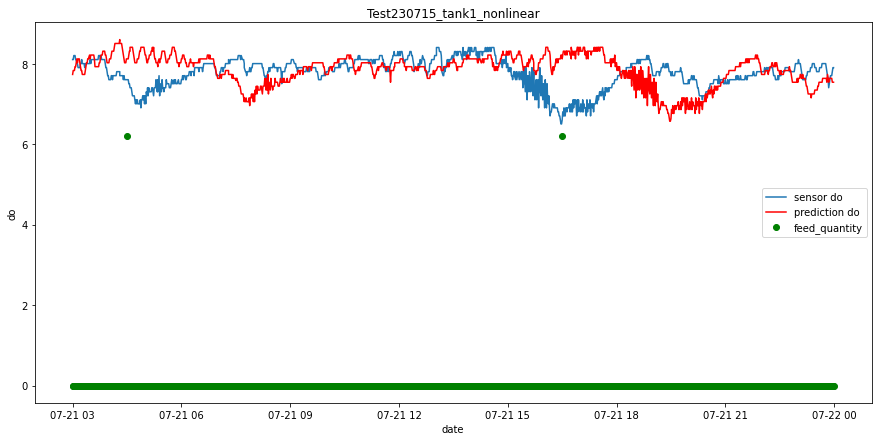

40/40 [==============================] - 0s 4ms/step - loss: 0.3335
MSE // MAE // R-squared  0.3335225582122803


In [25]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [26]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 2


In [27]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-21 14:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 720 nVar: 1


720


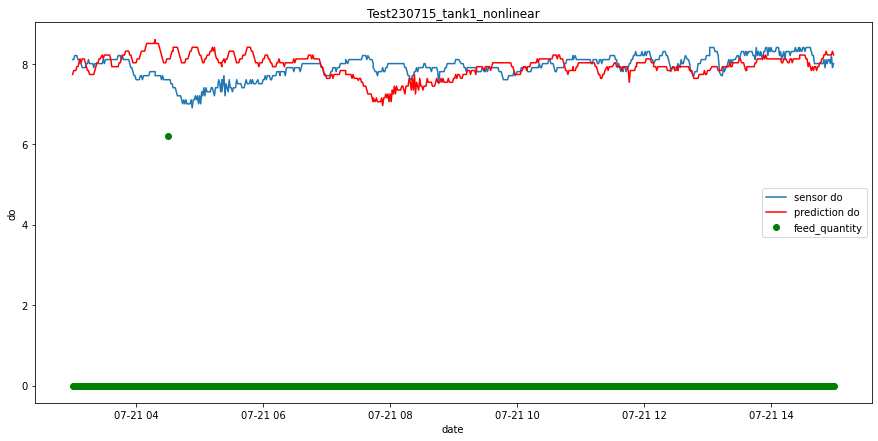

23/23 [==============================] - 0s 3ms/step - loss: 0.1949
MSE // MAE // R-squared  0.1948772817850113


In [28]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [29]:
japonica_validation_features_X.at['2021-07-21 08:00', 'feed_quantity'] = 6

X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 2


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [30]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-21 14:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 720 nVar: 1


720


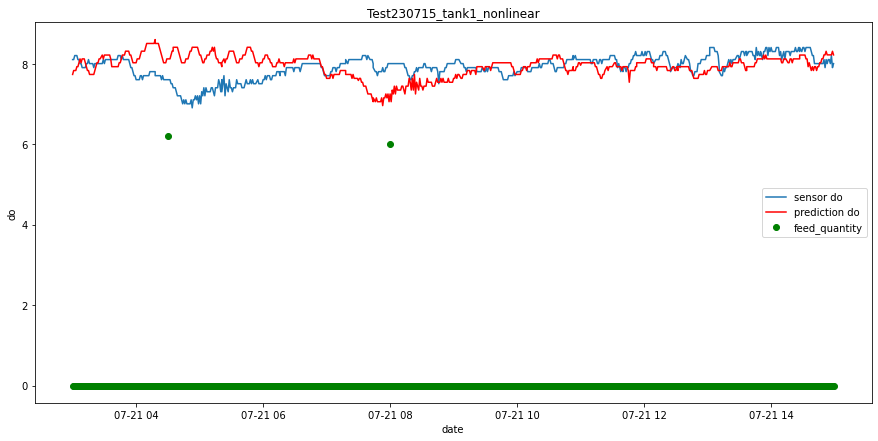

23/23 [==============================] - 0s 3ms/step - loss: 0.1949
MSE // MAE // R-squared  0.1948958933353424


In [31]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)